In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sbi.analysis import pairplot
import pickle
import yaml
import os
from sbc.sbc_tools import plot_sbc_all
from examples.gipps import plot_all

path_to_repo = "/Users/Lieve/Documents/Masters Project/SBC-SBI"
results_path = path_to_repo + "/results/real_examples/gipps_7d/npe_a"
trajectories_path = path_to_repo + "/results/real_examples/gipps_7d/trajectories"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Amortized NPE-A to infer Gipps parameters

In [ ]:
# We assume the following variables are fixed globally:
tau = 0.5
N = 100  # Number of tau-sized time steps to simulate
T = tau * N  # Total time simulated
psi = 1.05
ll = 7.5 # Length of leader car

# True follower parameters
af = 1.797
bf = -3.566
Vf = 28
xf0 = -22.521
vf0 = 10.148
mu = 0.8
sigmasquared = 0.25

# Define true parameter vector
true_theta = torch.tensor([af, bf, Vf, xf0, vf0, mu, sigmasquared])

# True leader parameters (all of these apart from bl are only needed for simulating leader trajectory).
# Note that these were not given in the paper
al = 2
bl = -4
Vl = 30
xl0 = 0
vl0 = 10
p_accel = 0.2
p_brake = 0.2

Retrieve the leader trajectory, which is fixed throughout the problem.

In [3]:
# Select leader trajectory ID
leader_trajectory_ID = 0

leader_trajectory_name = f"leader_trajectory{leader_trajectory_ID}"
path_to_leader_trajectory = trajectories_path + "/" + leader_trajectory_name + ".npz"
path_to_leader_trajectory_config = trajectories_path + "/" + leader_trajectory_name + ".yaml"

# Retrieve xl, vl
leader_trajectory = np.load(path_to_leader_trajectory)
xl = leader_trajectory["xl"]
vl = leader_trajectory["vl"]

# Retrieve leader trajectory config
with open(path_to_leader_trajectory_config, "r") as f:
    leader_trajectory_config = yaml.safe_load(f) # Dictionary containing all information about xl, vl

Retrieve the observed follower trajectory that we condition our inference on.

In [4]:
# Select observed follower trajectory ID
follower_trajectory_ID = 0

follower_trajectory_name = f"follower_trajectory{follower_trajectory_ID}_leader_trajectory{leader_trajectory_ID}"
path_to_follower_trajectory = trajectories_path + "/" + follower_trajectory_name + ".npz"
path_to_follower_trajectory_config = trajectories_path + "/" + follower_trajectory_name + ".yaml"

# Retrieve xf_obs, vf_obs
follower_trajectory = np.load(path_to_follower_trajectory)
xf_obs = follower_trajectory["xf"]
vf_obs = follower_trajectory["vf"]

# Retrieve follower trajectory config
with open(path_to_follower_trajectory_config, "r") as f:
    follower_trajectory_config = yaml.safe_load(f) # Dictionary containing all information about xf, vf

Plot follower and leader trajectories.

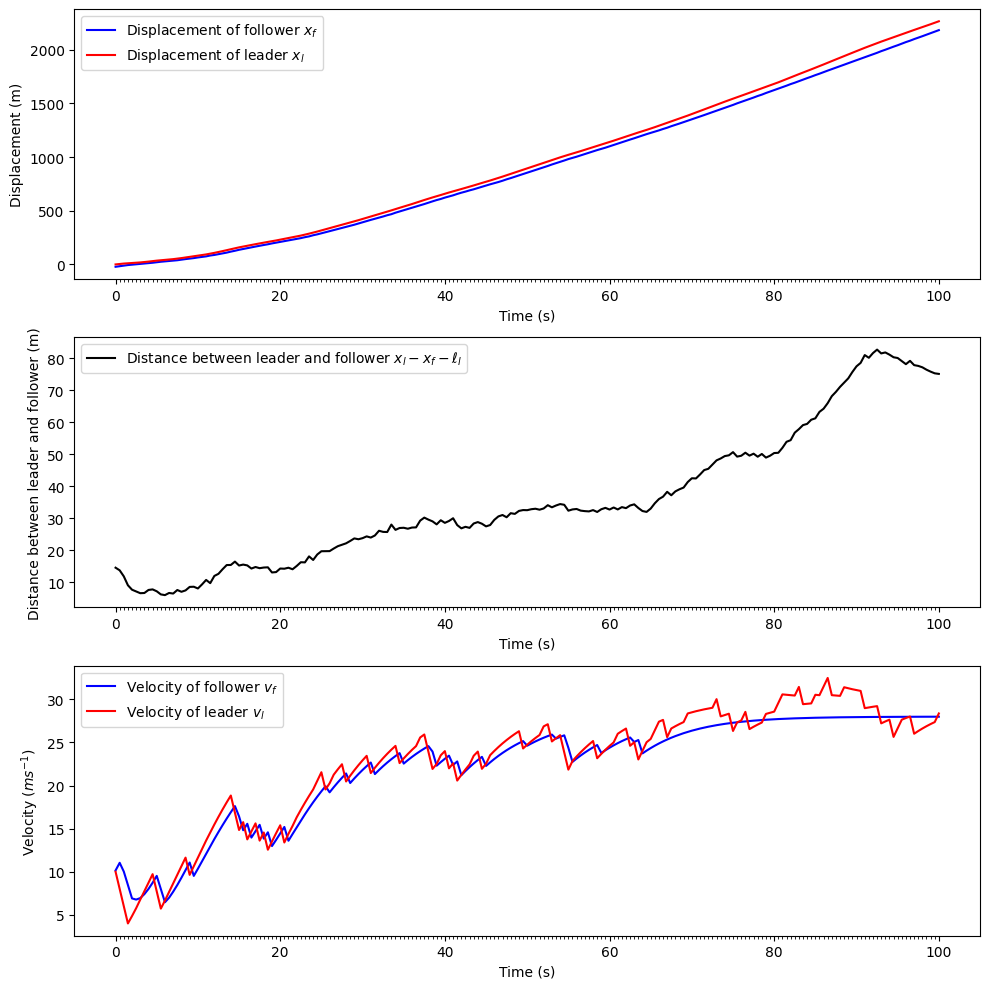

In [5]:
plot_all(xf_obs, vf_obs, xl, vl, tau, N, ll)

Denote the parameter vector as

$$\theta = (a_f, b_f, V_f, x_f(0), v_f(0), \mu, \sigma^2)$$

In [6]:
# NPE-A NEEDS UNOFORM OR GAUSSIAN PRIOR. THIS IS DIFFERENT FROM THE TRUE PRIORS USED IN PAPER

# Define prior hyperparameters
# We take the prior to be uniform in each parameter, with the following bounds:
aL, aU = 0.5, 3.5
bL, bU = -6, -1
VL, VU = 15, 35
xf0L, xf0U = -60, -10
vf0L, vf0U = 5, 25
muL, muU = -5, 5
sigmasquaredL, sigmasquaredU = 0, 3

# For plotting
prior_supports = [(aL, aU), (bL, bU), (VL, VU), (xf0L, xf0U), (vf0L, vf0U), (muL, muU), (sigmasquaredL, sigmasquaredU)]

In [7]:
# Select amortized posterior ID
amortized_posterior_ID = 0

amortized_posterior_name = f"amortized_posterior{amortized_posterior_ID}_leader_trajectory{leader_trajectory_ID}"
path_to_amortized_posterior = results_path + "/" + amortized_posterior_name + ".pkl"
path_to_amortized_posterior_config = results_path + "/" + amortized_posterior_name + ".yaml"

# Retrieve amortized posterior
with open(path_to_amortized_posterior, "rb") as f:
    amortized_posterior = pickle.load(f)

# Retrieve amortized posterior config
with open(path_to_amortized_posterior_config, "r") as f:
    amortized_posterior_config = yaml.safe_load(f) # Dictionary containing all information about this posterior.

In [8]:
amortized_posterior_samples = amortized_posterior.sample((10000,), x=xf_obs)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Clear non-identifiability issue with $x_f(0)$ and $v_f(0)$ (look at the correlations). Since if we start further back but have a larger initial velocity, we can achieve a very similar trajectory.

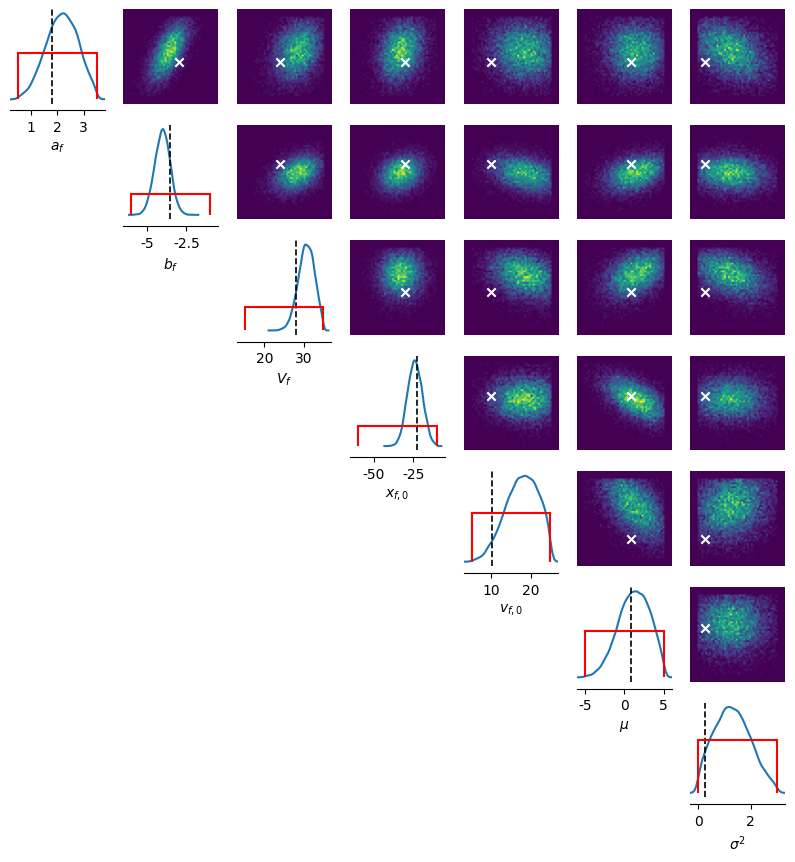

In [9]:
parameter_labels = [r"$a_f$", r"$b_f$", r"$V_f$", r"$x_{f,0}$", r"$v_{f,0}$", r"$\mu$", r"$\sigma^2$"]

fig = pairplot(amortized_posterior_samples,
         labels=parameter_labels,
         figsize=(10,10),
         diag="kde")

axes = fig[0].axes   # flat list of all subplots
dim = len(true_theta)

for i in range(dim):        # row index
    for j in range(dim):    # column index
        ax = axes[i * dim + j]

        if i == j:
            # Plot vertical line at true parameter value
            ax.axvline(true_theta[i], color="black", linestyle="--", linewidth=1.2)

            L = prior_supports[i][0]
            U = prior_supports[i][1]
            x = np.linspace(L, U, 1000)
            y = np.where((x >= L) & (x <= U), 1 / (U - L), 0.0)
            ax.plot(x, y, color="red")
            ax.vlines(x=L, ymin=0, ymax=1/(U-L), color="red")
            ax.vlines(x=U, ymin=0, ymax=1/(U-L), color="red")
            ax.set_xlim((L - 0.1*abs(U-L), U + 0.1*abs(U-L)))

        elif j > i:
            # 2D joint → horizontal AND vertical lines
            ax.scatter(true_theta[j], true_theta[i], color="white", marker="x")

## SBC on amortized NPE-A

In [16]:
amortized_sbc_ID = 0

path_to_amortized_sbc = results_path + f"/amortized_sbc{amortized_sbc_ID}_amortized_posterior{amortized_posterior_ID}_leader_trajectory{leader_trajectory_ID}" + ".npy"
path_to_amortized_sbc_config = results_path + f"/amortized_sbc{amortized_sbc_ID}_amortized_posterior{amortized_posterior_ID}_leader_trajectory{leader_trajectory_ID}" + ".yaml"

# Retrieve amortized sbc ranks
amortized_ranks = np.load(path_to_amortized_sbc)

# Retrieve amortized sbc config
with open(path_to_amortized_sbc_config, "r") as f:
    amortized_sbc_config = yaml.safe_load(f) # Dictionary containing all information about this sbc run.

# Get N_iter and N_samp from config file
N_iter = amortized_sbc_config["sbc_config"]["N_iter"]
N_samp = amortized_sbc_config["sbc_config"]["N_samp"]

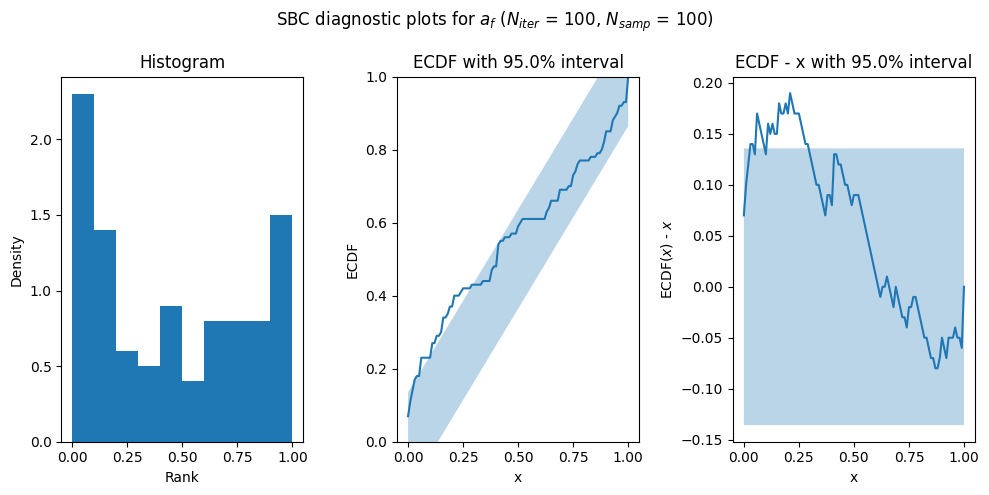

array([<Axes: title={'center': 'Histogram'}, xlabel='Rank', ylabel='Density'>,
       <Axes: title={'center': 'ECDF with 95.0% interval'}, xlabel='x', ylabel='ECDF'>,
       <Axes: title={'center': 'ECDF - x with 95.0% interval'}, xlabel='x', ylabel='ECDF($x$) - $x$'>],
      dtype=object)

In [ ]:
title=fr"SBC diagnostic plots for {parameter_labels[0]}" + r" ($N_{iter}$ = " + f"{N_iter}, " + r"$N_{samp}$ = " + f"{N_samp})"
plot_sbc_all(ranks=amortized_ranks, N_samp=N_samp, title=title)

# Sequential NPE-A (SNPE-A) to infer Gipps parameters

NOT WORKING DUE TO NON-SPD COVARIANCE MATRIX OF MDN

In particular, it's allowing us to train the MDN but not sample from it.

In [12]:
sequential_posterior_ID = 0

path_to_sequential_posterior = results_path + f"/sequential_posterior{sequential_posterior_ID}_follower_trajectory{follower_trajectory_ID}_leader_trajectory{leader_trajectory_ID}" + ".pkl"
path_to_sequential_posterior_config = results_path + f"/sequential_posterior{sequential_posterior_ID}_follower_trajectory{follower_trajectory_ID}_leader_trajectory{leader_trajectory_ID}" + ".yaml"

with open(path_to_sequential_posterior, "rb") as f:
    sequential_posterior = pickle.load(f)

In [13]:
samples = sequential_posterior.sample((10000,), x=xf_obs)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

AssertionError: The precision matrix of a posterior is not positive definite! This is a known issue for SNPE-A. Either try a different parameter setting, e.g. a different number of mixture components (when contracting SNPE-A), or a different value for the parameter perturbation (when building the posterior).

## SBC on SNPE-A

Clearly not working since we can't even get SNPE-A working.